# Spam/Ham Email Classification

### Goal: Create a classifier that can distinguish spam emails from non-spam ('ham') emails

*Disclaimer: Credit to staff of UC Berkeley Data100 Fall 2019 for project prompt and code outline

## Imports:

In [273]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

import warnings
warnings.simplefilter(action='ignore')

## Loading in the Data

In [274]:
original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


## Training Validation Split

In [275]:
#Splitting the training data into separate training and validation datsets
train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

# Part I - Initial Analysis

## 1: Basic Feature Engineering 

### 1a) Creating function called words_in_texts

In [276]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    match = [(x in y) for y in texts for x in words]
    match = np.array(match).astype(int) 
    length = len(texts)
    arrs = np.hsplit(np.array(match), length)
    indicator_array = np.array(arrs)
    return indicator_array

## 2: Basic EDA

### 2a) Comparing the proportion of spam and ham emails containing certain words

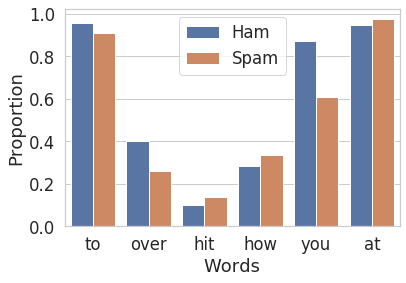

In [277]:
train=train.reset_index(drop=True) 

words = ['to', 'over', 'hit', 'how', 'you', 'at']

spam = train[train["spam"]==1]
ham = train[train["spam"]==0]

spam_match = words_in_texts(words, spam['email'])
ham_match =words_in_texts(words, ham['email'])


spam_p = [np.sum(x)/len(spam) for x in spam_match.T] #spam proportion
ham_p= [np.sum(x)/len(ham) for x in ham_match.T] #ham proportion

spam_and_ham_props = np.append(spam_p,ham_p)


df = {'Type': np.append(len(words) * ["Ham"],len(words) * ["Spam"]),
        'Words': words * 2,
        'Proportion':spam_and_ham_props}
frame = pd.DataFrame(df)

sns.barplot(x = 'Words', y = 'Proportion', hue=df['Type'], data=frame) 

### 2b) Comparing the distribution of the length of spam emails to the distribution of the length of ham emails in the training set

Text(0, 0.5, 'Distribution')

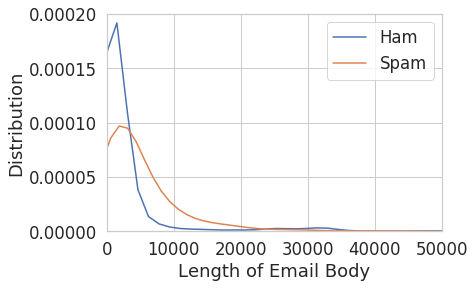

In [278]:
train=train.reset_index(drop=True)

spam,ham = train[train["spam"]==1],train[train["spam"]==0]



sns.distplot(ham['email'].apply(len), label = 'Ham',hist=False)
sns.distplot(spam['email'].apply(len), label = 'Spam',hist=False)

plt.xlim(0,50000)
plt.ylim(0,.0002)
plt.legend()
plt.xlabel('Length of Email Body')
plt.ylabel('Distribution')

## 3: Classification

In [279]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = np.array(train['spam'])

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 array([0, 0, 0, 0, 0]))

In [280]:
model = LogisticRegression() 
model.fit(X_train, Y_train) 

training_accuracy = model.score(X_train, Y_train) 
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


# Part II - Increasing the Accuracy of the Spam Filter
## Feature Selection and Creation


### Number of words
#### Comparing the distribution of the number of words in spam emails to the distribution of the number of words in ham emails

Text(0, 0.5, 'Distribution')

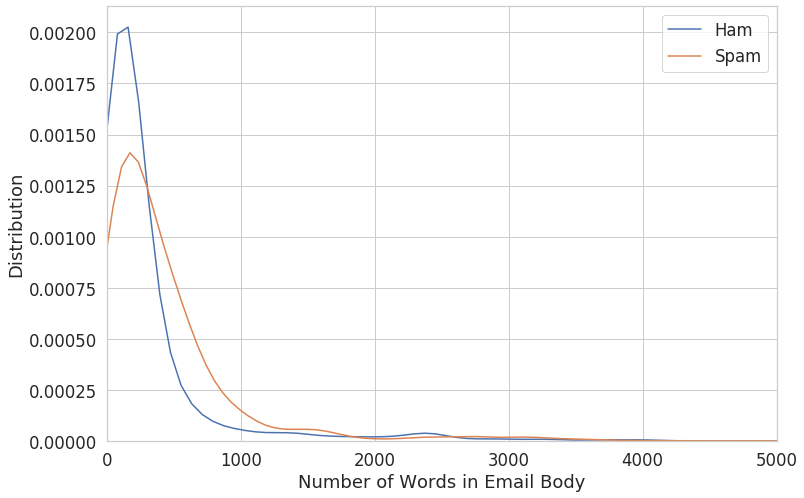

In [281]:
#Adds columns for number of words in email body
def num_words(df):
    df['num_words_email'] = df['email'].str.split().str.len()
    return df

modified_df = num_words(train)


spam = modified_df[modified_df["spam"]==1]
ham = modified_df[modified_df["spam"]==0]

#Plotting number of words in email
sns.distplot(ham['num_words_email'], label = 'Ham',hist=False)
sns.distplot(spam['num_words_email'], label = 'Spam',hist=False)

fig = plt.gcf()
fig.set_size_inches(12, 8)

plt.xlim(0,5000)
plt.legend()
plt.xlabel('Number of Words in Email Body')
plt.ylabel('Distribution')

### Number of html tags
#### Comparing the distribution of the number of html tags in spam emails to the distribution of the number of  html tags in ham emails

Text(0, 0.5, 'Distribution')

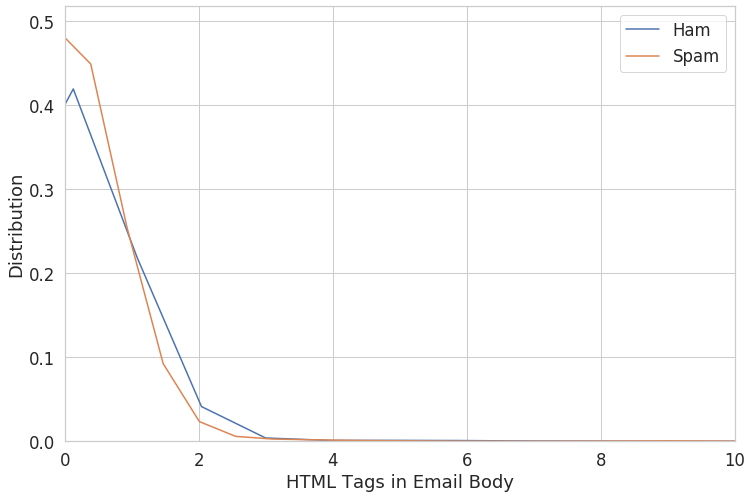

In [282]:
#Adds columns for number of html tags in email body
def num_html_tag(df):
    df['num_html_tag_email'] = df["email"].str.count("/>")
    return df

modified_df = num_html_tag(train)


spam = modified_df[modified_df["spam"]==1]
ham = modified_df[modified_df["spam"]==0]


sns.distplot(ham['num_html_tag_email'], label = 'Ham',hist=False)
sns.distplot(spam['num_html_tag_email'], label = 'Spam',hist=False)

fig = plt.gcf()
fig.set_size_inches(12, 8)

plt.xlim(0,10)
plt.legend()
plt.xlabel('HTML Tags in Email Body')
plt.ylabel('Distribution')

### Special characters
#### Comparing the proportion of spam and ham emails containing special characters

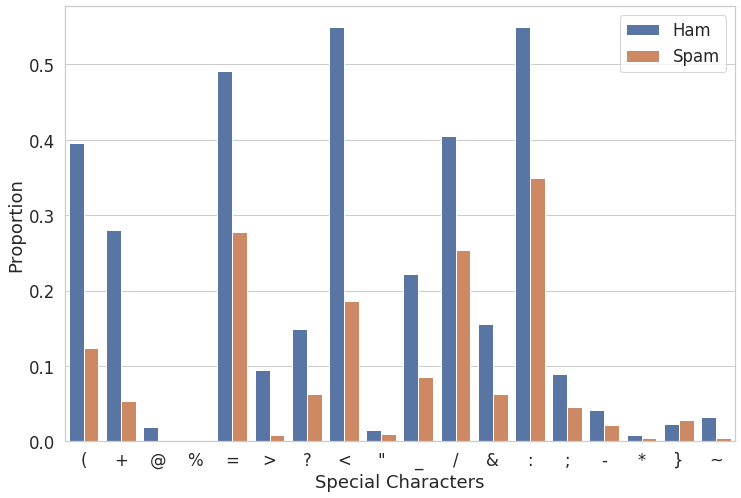

In [284]:
train=train.reset_index(drop=True) 

characters = ['(','+','@','%','=','>','?','<','"','_', '/',
                   '&',':','>',';','-','*','}','~']

spam = train[train["spam"]==1]
ham = train[train["spam"]==0]

spam_match = words_in_texts(spam_trigger, spam['email'])
ham_match = words_in_texts(spam_trigger, ham['email'])

spam_p = [np.sum(x)/len(spam) for x in spam_match.T] #spam proportion
ham_p = [np.sum(x)/len(ham) for x in ham_match.T] #ham proportion

spam_and_ham_props = np.append(spam_p,ham_p)

df = {'Type': np.append(len(characters) * ["Ham"],len(characters) * ["Spam"]),
        'Special Characters': characters * 2,
        'Proportion':spam_and_ham_props}
frame = pd.DataFrame(df)

sns.barplot(x = 'Special Characters', y = 'Proportion', hue=df['Type'], data=frame,ci=None) 
fig = plt.gcf()
fig.set_size_inches(12, 8)

#### Comparing the distribution of the number of special characters in spam emails to the distribution of the number of special characters in ham emails

Text(0, 0.5, 'Distribution')

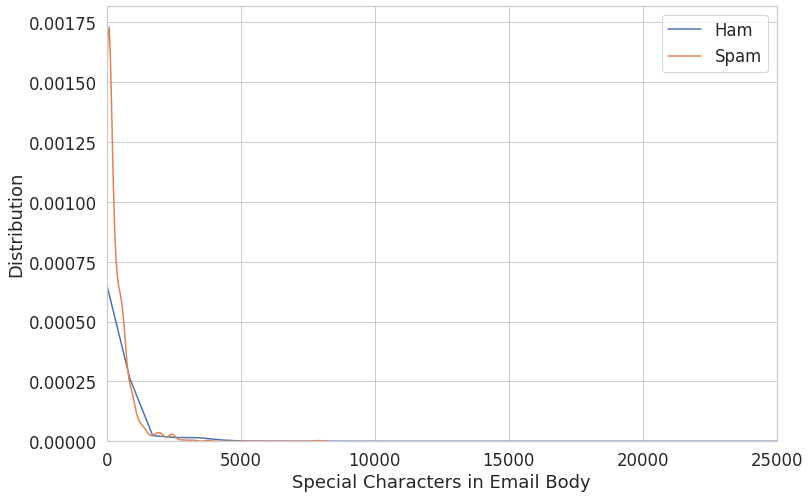

In [285]:
modified_df = num_special_char(train)


spam = modified_df[modified_df["spam"]==1]
ham = modified_df[modified_df["spam"]==0]


sns.distplot(ham['num_special_characters_email'], label = 'Ham',hist=False)
sns.distplot(spam['num_special_characters_email'], label = 'Spam',hist=False)

fig = plt.gcf()
fig.set_size_inches(12, 8)

plt.xlim(0,25000)
plt.legend()
plt.xlabel('Special Characters in Email Body')
plt.ylabel('Distribution')

### Spam Trigger Words/Phrases
#### Comparing the proportion of spam and ham emails containing typical spam trigger words/phrases

In [286]:
spam_trigger = ['$','100%','100% free','100% satisfied','free','guarantee','earn','click','winner',
                   'action', 'win','buy','act','affordable','claim','apply','clearance','cheap','urgent']

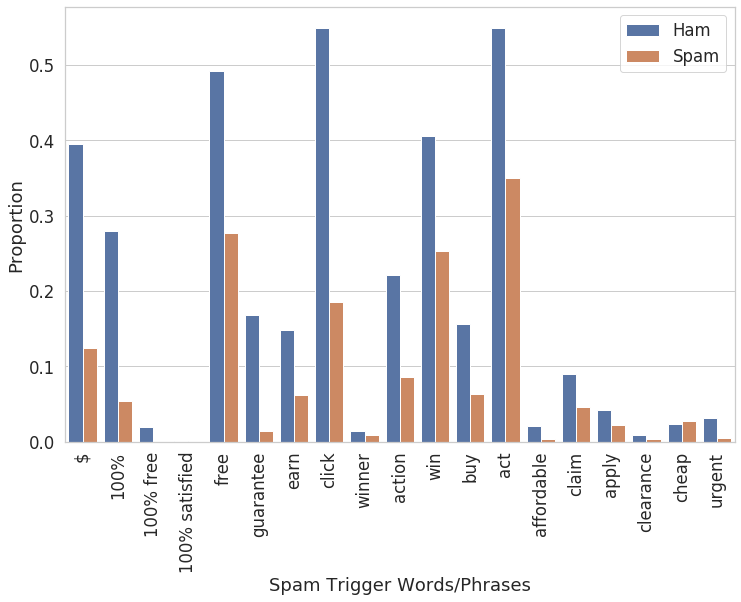

In [287]:
train=train.reset_index(drop=True) 


spam = train[train["spam"]==1]
ham = train[train["spam"]==0]

spam_match = words_in_texts(spam_trigger, spam['email'])
ham_match = words_in_texts(spam_trigger, ham['email'])

spam_p = [np.sum(x)/len(spam) for x in spam_match.T] #spam proportion
ham_p = [np.sum(x)/len(ham) for x in ham_match.T] #ham proportion

spam_and_ham_props = np.append(spam_p,ham_p)


df = {'Type': np.append(len(spam_trigger) * ["Ham"],len(spam_trigger) * ["Spam"]),
        'Spam Trigger Words/Phrases': spam_trigger * 2,
        'Proportion':spam_and_ham_props}
frame = pd.DataFrame(df)

sns.barplot(x = 'Spam Trigger Words/Phrases', y = 'Proportion', hue=df['Type'], data=frame,ci=None)

plt.xticks(rotation=90)
fig = plt.gcf()
fig.set_size_inches(12, 8)

### Functions for Feature Creation

In [288]:
#Length of email body and subject
def long(df):
    df['email_length'] = df['email'].str.len()
    df['subject_length'] = df['subject'].str.len()
    return df

#Number of words in email body
def num_words(df):
    df['num_words_email'] = df['email'].str.split().str.len()
    return df

#Number of special characters in email body and subject
def num_special_char(df):
    df['num_special_characters_email'] = df['email'].str.findall('[@_!#$%^&*()<>?/\|}{~:]').str.len()
    df['num_special_characters_subject'] = df['subject'].str.findall('[@_!#$%^&*()<>?/\|}{~:]').str.len()
    return df

#Number of html tags in email body
def num_html_tag(df):
    df['num_html_tag_email'] = df["email"].str.count("/>")
    return df

### Improving the Model and its Accuracy
#### *Increased Accruacy from 75% to 90%*

In [291]:
def improve_df(df):
    df["subject"].fillna(" ", inplace=True)
    some_words = ['collect', 'prize','size','call','now','href', 'offer', '.org',
                  'url','your', 'fast', 'wrote','date','time','src=','offer'] + spam_trigger
    
    X_train = np.array(words_in_texts(some_words, df['email'])).astype(int)
    feature = pd.concat([
        long(df),
        num_words(df), 
        num_special_char(df),
        num_html_tag(df)], axis=1).values
    return X_train

X_train = improve_df(train)
Y_train = train['spam']

improved_model = LogisticRegression()
improved_model.fit(X_train, Y_train)

training_accuracy = improved_model.score(X_train, Y_train)
training_accuracy
print("Training Accuracy of Improved Model: ", training_accuracy)

Training Accuracy of Improved Model:  0.9032343937175562


# EDA Visualization

#### Scatter plot comparing the number of special characters and normal characters in both ham and spam emails



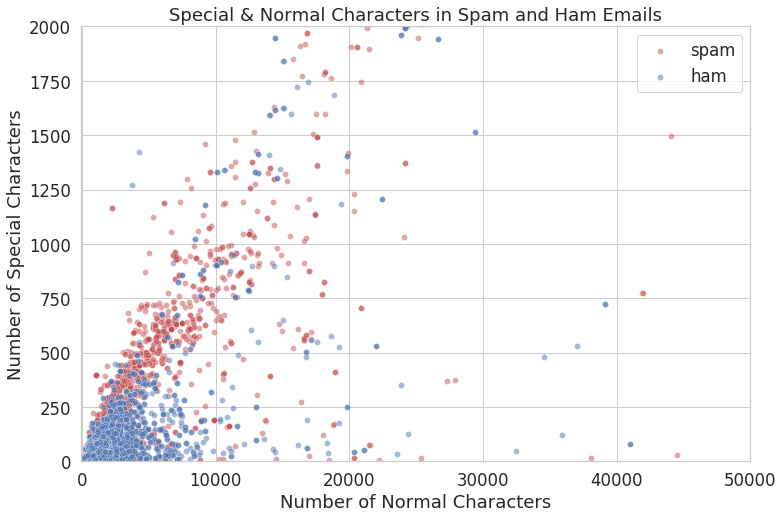

In [292]:
fig = plt.gcf()
fig.set_size_inches(12, 8)

train_df=train.reset_index(drop=True) 
spam = train_df[train_df["spam"]==1]
ham = train_df[train_df["spam"]==0]

train_df['spam special char'] = spam['email'].str.count('[|@|_|!|#|$|%|^|&|*|(|)|<|>|?|/|\|}|{|~|:|]')
train_df['ham special char'] = ham['email'].str.count('[|@|_|!|#|$|%|^|&|*|(|)|<|>|?|/|\|}|{|~|:|]')
train_df['spam char'] = spam['email'].str.len()
train_df['ham char'] = ham['email'].str.len()

train_df = train_df.replace('nan', np.nan).fillna(0)

spam_df = train_df.query("spam >0")
ham_df = train_df.query("spam == 0")

sns.scatterplot(x="spam char", y="spam special char", data=spam_df,alpha=.5,color = 'r');
sns.scatterplot(x="ham char", y="ham special char", data=ham_df, alpha=.5,color = 'b');
plt.xlabel('Number of Normal Characters')
plt.ylabel('Number of Special Characters')
plt.title('Special & Normal Characters in Spam and Ham Emails')

plt.xlim(-100,50000)
plt.ylim(0,2000)
plt.legend(labels=['spam', 'ham'])

#### Correlation between features

[]

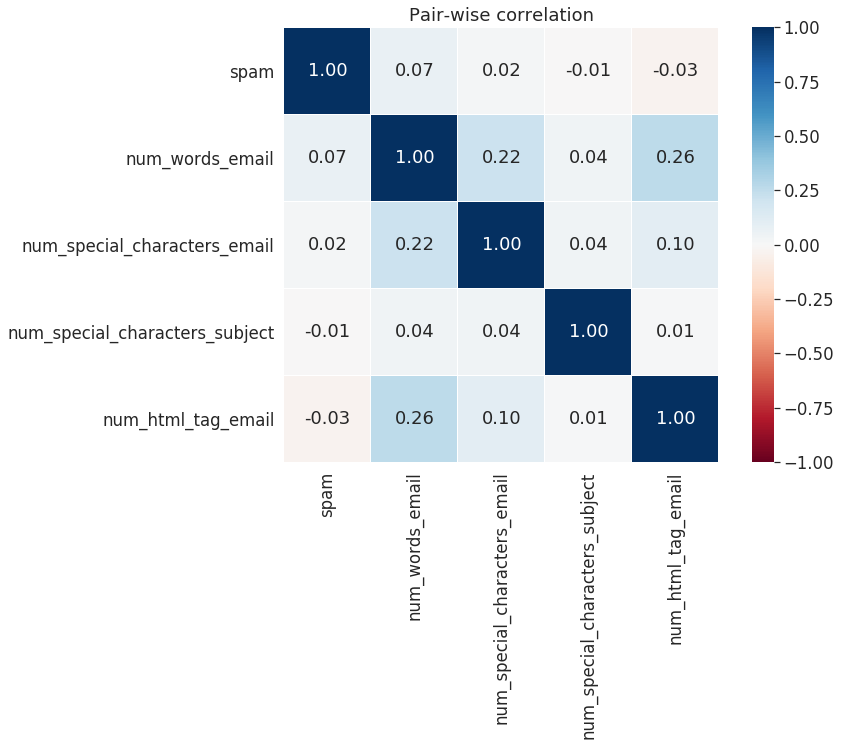

In [293]:
corr_cols = ['spam','num_words_email','num_special_characters_email',
             'num_special_characters_subject','num_html_tag_email']
colormap = plt.cm.RdBu
plt.figure(figsize=(12, 8))
sns.heatmap(train[corr_cols].astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1., square=True, cmap=colormap, linecolor='white', annot=True,fmt=".2f")
plt.title('Pair-wise correlation')
plt.plot()

# ROC Curve for Final Classifier/Model

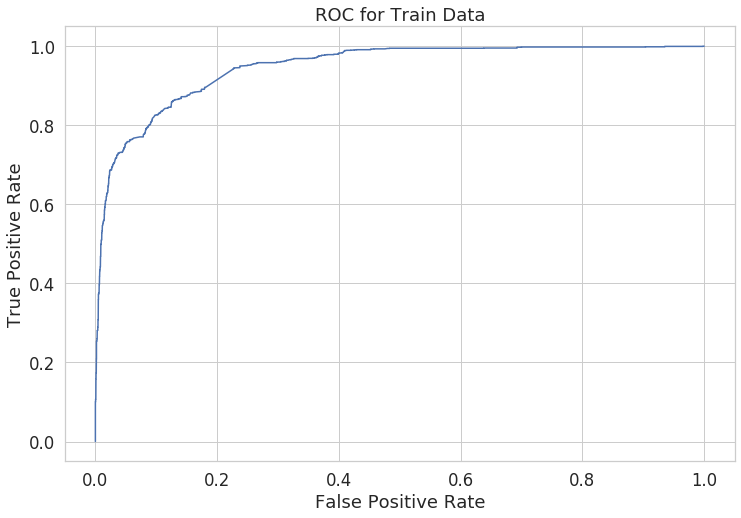

In [294]:
fig = plt.gcf()
fig.set_size_inches(12, 8)


probabilities = improved_model.predict_proba(X_train) 
predictions = probabilities[:,1]
fp_rate, tp_rate, threshold = roc_curve(Y_train, predictions) 


plt.plot(fp_rate, tp_rate, 'b')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Train Data')
plt.show()